## XGBoost Regression

XGBoost (Extreme Gradient Boosting) is a powerful ensemble model that builds trees sequentially, 
where each new tree corrects the errors of the previous ones.

Key advantages:
- Handles non-linear relationships and feature interactions
- Built-in regularization to reduce overfitting
- Robust to outliers and skewed targets
- Often achieves state-of-the-art performance on tablar data


## 1) Importing Required Libraries and Dependencies

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
os.chdir('D:/ds/ml/Medical_Insurance_Cost-main')

## 2) Dataset Loading and Initial Inspection

The insurance dataset contains demographic, lifestyle, and regional attributes of individuals along with their corresponding medical insurance charges.  
Initial inspection is performed to understand the structure, data types, and completeness of the dataset.


In [3]:
df=pd.read_csv('insurance.csv')

In [4]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
df.nunique()

age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64

In [6]:
df.region.value_counts()

region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64

In [7]:
df.sex.value_counts()

sex
male      676
female    662
Name: count, dtype: int64

In [8]:
df.smoker.value_counts()

smoker
no     1064
yes     274
Name: count, dtype: int64

## 3) Target Variable Distribution (Medical Insurance Charges)

Text(0.5, 1.0, 'Distribution Of Medical Insrance Charges')

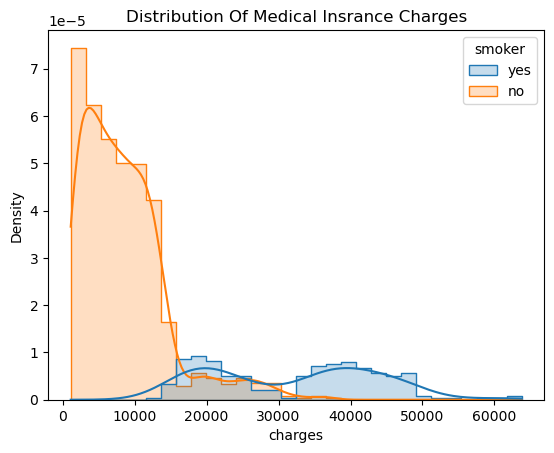

In [9]:
sns.histplot(
    data=df,
    x='charges',
    kde=True,
    hue='smoker',
    stat='density',
    element='step'
)
plt.title("Distribution Of Medical Insrance Charges")

The target variable `charges` represents medical insurance costs.  
Its distribution is **right-skewed**, which violates the normality assumption of linear regression.

To stabilize variance and improve model performance, a **log transformation** of the target variable is applied.

In [10]:
df['log_charges'] = np.log(df['charges'])
df[['charges', 'log_charges']].head()

,charges,log_charges
0,16884.92400,9.734176
1,1725.55230,7.453302
2,4449.46200,8.400538
3,21984.47061,9.998092
4,3866.85520,8.260197


Text(0.5, 1.0, 'Log Charges Distribution')

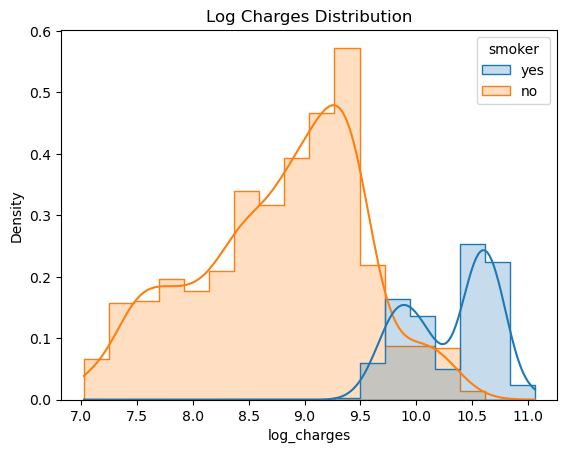

In [11]:
sns.histplot(
    data=df,
    x='log_charges',
    kde=True,
    stat='density',
    hue='smoker',
    element='step'
)
plt.title("Log Charges Distribution")

## 4) Features and Targets

In [12]:
# Features
X = df.drop(['charges', 'log_charges'], axis=1)

# Target
y = df['charges']

## 5) Categorical Feature Encoding

The dataset contains both numerical and categorical variables.  
Since machine learning models require numerical inputs, categorical variables must be encoded appropriately.

To avoid introducing artificial ordering and data leakage, categorical variables are encoded using **One-Hot Encoding** within a preprocessing pipeine.
.


### 5(a) Identifying Categorical & Numerical Columns

In [13]:
# Identify categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Remove target variables from numerical list
numerical_cols.remove('charges')
numerical_cols.remove('log_charges')

In [14]:
print("Categorical Features : ", categorical_cols)
print("Numerical Features : ", numerical_cols)

Categorical Features :  ['sex', 'smoker', 'region']
Numerical Features :  ['age', 'bmi', 'children']


#### **Numerical & Categorical Features and Target**
- Numerical features : `['age', 'bmi', 'children']`
- Categorical Features : `['sex', 'smoker', 'region']`
- Target : `['log_charges']`

### 5(b) Column Transformer

In [15]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ],
    remainder = 'passthrough'
)

## 6) Pipeline with XGBoost Regressor

In [16]:
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

xgb_model = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('regressor', XGBRegressor(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1
    ))
])

## 7) Train-Test-Split

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

## 8) Model Training

In [18]:
xgb_model.fit(X_train, y_train)

,steps,"[('preprocessing', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## 9) Model Evaluation

In [19]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

train_pred = xgb_model.predict(X_train)
test_pred  = xgb_model.predict(X_test)

print(f"XGBoost Train R2: {r2_score(y_train, train_pred):.4f}")
print(f"XGBoost Test  R2: {r2_score(y_test, test_pred):.4f}")
print(f"XGBoost Test RMSE: {np.sqrt(mean_squared_error(y_test, test_pred)):.4f}")

XGBoost Train R2: 0.9790
XGBoost Test  R2: 0.8616
XGBoost Test RMSE: 4634.8483


## 10) Hyperparameter Tuning

In [20]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'regressor__n_estimators': [200, 300],
    'regressor__max_depth': [4, 6, 8],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__subsample': [0.8, 1.0]
}

In [21]:
xgb_gs = GridSearchCV(
    xgb_model,
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

xgb_gs.fit(X_train, y_train)

,estimator,"Pipeline(step...=None, ...))])"
,param_grid,"{'regressor__learning_rate': [0.05, 0.1], 'regressor__max_depth': [4, 6, ...], 'regressor__n_estimators': [200, 300], 'regressor__subsample': [0.8, 1.0]}"
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('cat', ...)]"


In [22]:
best_xgb = xgb_gs.best_estimator_
best_xgb

,steps,"[('preprocessing', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## 11) Best XGBoost Model

In [23]:
best_xgb_pred = best_xgb.predict(X_test)

print(f"Best XGB Test R²: {r2_score(y_test, best_xgb_pred):.4f}")
print(f"Best XGB Test RMSE: {np.sqrt(mean_squared_error(y_test, best_xgb_pred)):.4f}")

Best XGB Test R²: 0.8788
Best XGB Test RMSE: 4337.8189


## 12) Feature Imprtance

In [24]:
cat_features = best_xgb.named_steps['preprocessing'] \
    .named_transformers_['cat'] \
    .get_feature_names_out(categorical_cols)

feature_names = list(cat_features) + numerical_cols

In [25]:
importances = best_xgb.named_steps['regressor'].feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

feature_importance_df

,Feature,Importance
1,smoker_yes,0.913724
6,bmi,0.032865
5,age,0.025617
7,children,0.007772
3,region_southeast,0.006384
0,sex_male,0.005081
4,region_southwest,0.004586
2,region_northwest,0.003972


## Why XGBoost Performs Best

XGBoost outperforms other models because it:
- Learns complex non-linear relationships
- Corrects previous model errors sequentially
- Uses regularization to control overfitting
- Effectively handles interactions between fetures
